# gnomAD Data Analysis

Importing necessary libraries

In [1]:
import hail as hl
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import random
import warnings

Loading BokehJS ...

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning, message="shade is now deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="is_categorical_dtype is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")

Initialising hail , which will be used read the genome data stored in the vcf file

In [3]:
hl.init()

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/Users/sambhavjain/anaconda3/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://192.168.1.102:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.124-13536b531342
LOGGING: writing to /Users/sambhavjain/Downloads/hail-20231015-1811-0.2.124-13536b531342.log


Importing the given vcf file using hail and set reference_genome to GRCh38 .<br>
I have changed reference genome because we have locus(Contig 'chrY') which is not there in the default reference genome.<br> 
This I figured after importing without 'GRCh38' and later analysing the error.

In [4]:
vcf_bgz_file = 'gnomad.genomes.v3.1.2.sites.chrY.vcf.bgz'

In [5]:
mt = hl.import_vcf(vcf_bgz_file, reference_genome = 'GRCh38')

In [6]:
print("Row Keys:")
print(mt.rows().key)

print("\nColumn Keys:")
print(mt.cols().key)

Row Keys:
<StructExpression of type struct{locus: locus<GRCh38>, alleles: array<str>}>

Column Keys:
<StructExpression of type struct{s: str}>


2023-10-15 18:11:21.878 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


In [7]:
mt.show()

2023-10-15 18:11:26.197 Hail: INFO: scanning VCF for sortedness...
2023-10-15 18:11:42.824 Hail: INFO: Coerced sorted VCF - no additional import work to do


,
locus,alleles
locus<GRCh38>,array<str>
chrY:2781489,"[""C"",""T""]"
chrY:2781499,"[""C"",""A""]"
chrY:2781511,"[""C"",""G""]"
chrY:2781514,"[""C"",""A""]"
chrY:2781520,"[""G"",""C""]"
chrY:2781522,"[""G"",""C""]"
chrY:2781554,"[""G"",""A""]"
chrY:2781557,"[""C"",""G""]"


## Why we use the allele at the index 1 for calculating the allele frequencies?
- **Common Variant Focus**: Using `[1]` allows us to prioritize the study of common genetic variants, which are more likely to be relevant in genetic analyses.
- **Statistical Power**: Focusing on the first alternate allele maximizes our ability to detect associations in genetic association studies.
- **Disease Association**:  For many complex diseases, the first alternate allele is more likely to be associated with disease risk or traits. Therefore, it is crucial to determine its frequency to assess its potential impact on health outcomes
- **Biological Significance**: The first alternate allele often carries the most biologically significant genetic variation.


In [8]:
allele_freqs = mt.aggregate_rows(hl.agg.counter(mt.alleles[1]))

# Data Visualization 

In [9]:
sorted_allele_freqs = sorted(allele_freqs.items(), key=lambda x: -x[1])

# Extract the first 100 allele frequencies and their corresponding alleles
first_100_frequencies = [freq for _, freq in sorted_allele_freqs[:100]]
first_100_alleles = [allele for allele, _ in sorted_allele_freqs[:100]]

# Create an interactive scatter plot
fig = px.scatter(x=first_100_alleles, y=first_100_frequencies, labels={'x': 'Alleles', 'y': 'Frequency'})
fig.update_traces(marker=dict(size=5), line=dict(width=2))
fig.update_xaxes(tickangle=45)
fig.update_layout(title='Interactive Plot of Allele Frequencies for the First 100 Alleles in Sorted Order of Frequencies', xaxis_title='Alleles', yaxis_title='Frequency')

# Show the interactive plot
fig.show()

In [10]:
# Shuffle the sorted allele frequencies list
random.shuffle(sorted_allele_freqs)

# Specify the number of random data points you want to plot
num_random_points = 100  # You can adjust this number as needed

# Extract the specified number of random allele frequencies and their corresponding alleles
random_frequencies = [freq for _, freq in sorted_allele_freqs[:num_random_points]]
random_alleles = [allele for allele, _ in sorted_allele_freqs[:num_random_points]]

# Create an interactive scatter plot for the random data points
fig = px.scatter(x=random_alleles, y=random_frequencies, labels={'x': 'Alleles', 'y': 'Frequency'})
fig.update_traces(marker=dict(size=5), line=dict(width=2))
fig.update_xaxes(tickangle=45)
fig.update_layout(title=f'Interactive Plot of Allele Frequencies for {num_random_points} Randomly Chosen Alleles', xaxis_title='Alleles', yaxis_title='Frequency')

# Show the interactive plot
fig.show()


### The CDF is a straight line which means that the number of alleles with very low frequency are quite large and there are only very few alleles which have high frequency

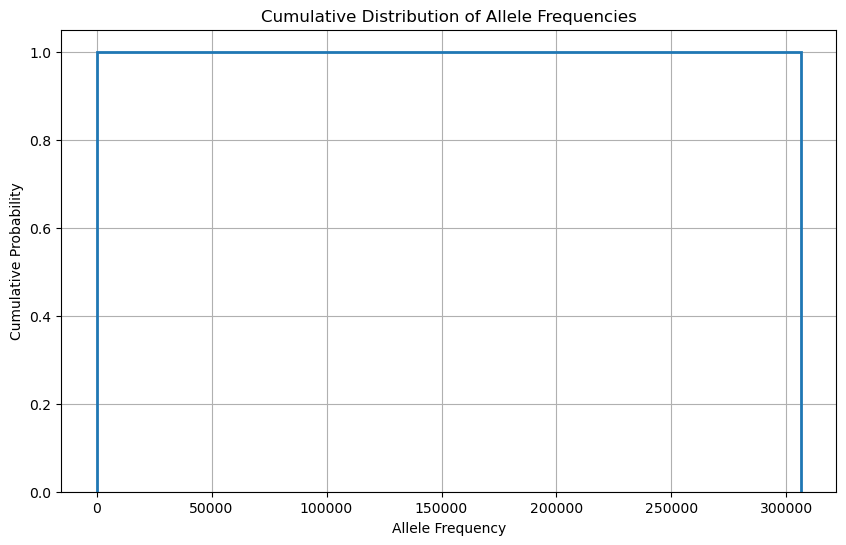

In [11]:
frequencies = [freq for _, freq in sorted_allele_freqs]

# Create a cumulative distribution plot
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=100, cumulative = True, density=True, histtype='step', linewidth=2)
plt.xlabel('Allele Frequency')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Allele Frequencies')
plt.grid(True)
plt.show()

### The same can be seen in the Kernel Density Estimation plot

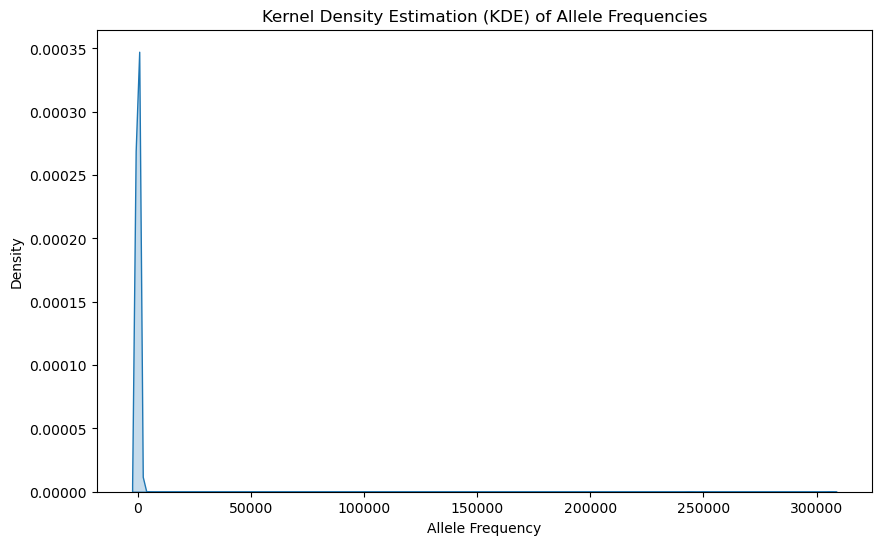

In [12]:
plt.figure(figsize=(10, 6))
sns.kdeplot(frequencies, fill=True)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) of Allele Frequencies')
plt.show()


### Shorter alleles are much more frequent than the longer alleles.

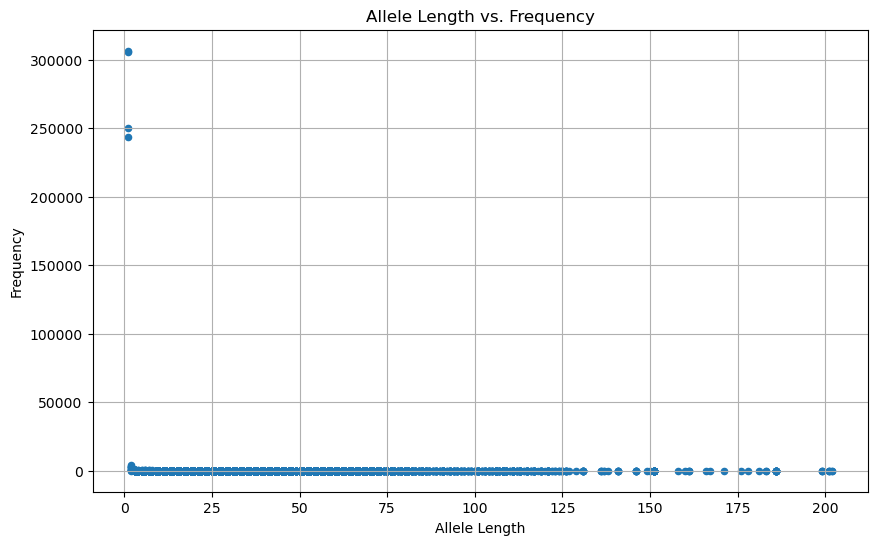

In [13]:
# Extract the alleles and their frequencies
alleles, frequencies = zip(*sorted_allele_freqs)

# Calculate the length of each allele
allele_lengths = [len(allele) for allele in alleles]

# Create a scatter plot of allele length vs. frequency
plt.figure(figsize=(10, 6))
plt.scatter(allele_lengths, frequencies, marker='o', s=20)
plt.title('Allele Length vs. Frequency')
plt.xlabel('Allele Length')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

# 10 MOST FREQUENT ALLELES

In [14]:
sorted_allele_freqs = sorted(allele_freqs.items(), key=lambda x: -x[1])

# Get the top 10 variants with the highest allele frequencies
top_10_variants = sorted_allele_freqs[:10]

# Print the top 10 variants with the highest allele frequencies
for i, (variant, freq) in enumerate(top_10_variants, 1):
    print(f"Top {i}: {variant} - Allele Frequency: {freq}")

# Stop Hail
hl.stop()

Top 1: A - Allele Frequency: 306422
Top 2: T - Allele Frequency: 305685
Top 3: C - Allele Frequency: 250236
Top 4: G - Allele Frequency: 243792
Top 5: AT - Allele Frequency: 3939
Top 6: TA - Allele Frequency: 3184
Top 7: CA - Allele Frequency: 2942
Top 8: CT - Allele Frequency: 2801
Top 9: GA - Allele Frequency: 2621
Top 10: GT - Allele Frequency: 2262


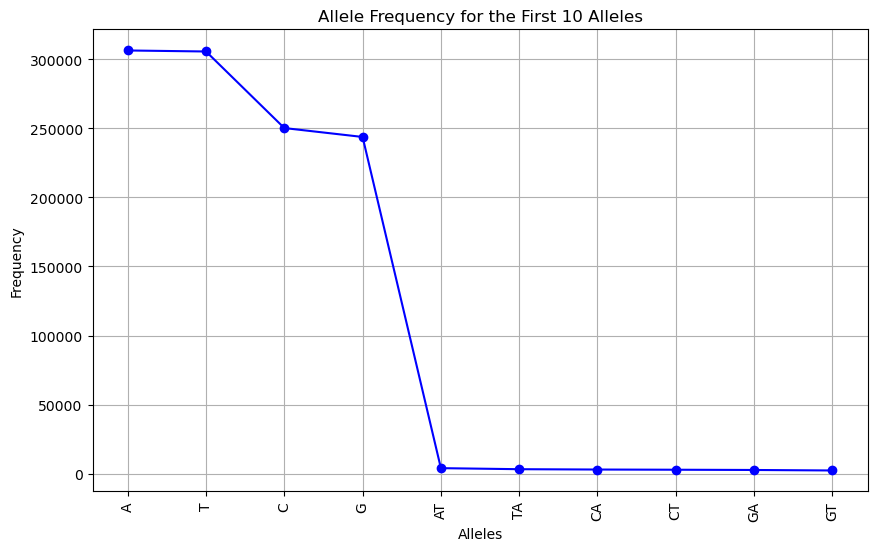

In [15]:
import matplotlib.pyplot as plt

# Extract the first 100 allele frequencies and their corresponding alleles
first_10_frequencies = [freq for _, freq in sorted_allele_freqs[0:10]]
first_10_alleles = [allele for allele, _ in sorted_allele_freqs[0:10]]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(first_10_alleles, first_10_frequencies, marker='o', linestyle='-', color='blue')
plt.xlabel('Alleles')
plt.ylabel('Frequency')
plt.title('Allele Frequency for the First 10 Alleles')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()
